In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aditya099","key":"bd64ed3d16b771e73eb8e91401ff1d14"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:39<00:00, 20.1MB/s]
100% 812M/812M [00:39<00:00, 21.7MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

Copying images to training, validation, and test directories

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Building the model

Instantiating a small convnet for dogs vs. cats classification


In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x= layers.Dense(512,activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

**Configuring the model for training**

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Data preprocessing

**Using `image_dataset_from_directory` to read images**



In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [13]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [14]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras.x",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/30
63/63 [==============================] - 22s 121ms/step - loss: 1.4351 - accuracy: 0.4975 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 2/30
63/63 [==============================] - 5s 83ms/step - loss: 0.7050 - accuracy: 0.5045 - val_loss: 0.6927 - val_accuracy: 0.4990
Epoch 3/30
63/63 [==============================] - 7s 107ms/step - loss: 0.6936 - accuracy: 0.5020 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 5s 79ms/step - loss: 0.6939 - accuracy: 0.5015 - val_loss: 0.6889 - val_accuracy: 0.5380
Epoch 5/30
63/63 [==============================] - 5s 82ms/step - loss: 0.6940 - accuracy: 0.5245 - val_loss: 0.6843 - val_accuracy: 0.6030
Epoch 6/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6823 - accuracy: 0.5805 - val_loss: 0.7302 - val_accuracy: 0.5450
Epoch 7/30
63/63 [==============================] - 5s 75ms/step - loss: 0.6844 - accuracy: 0.6115 - val_loss: 0.6896 - val_accuracy: 0.5550
Epoch 8/30

Displaying curves of loss and accuracy during training

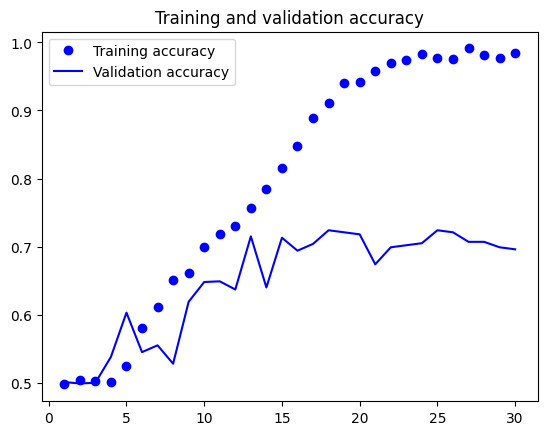

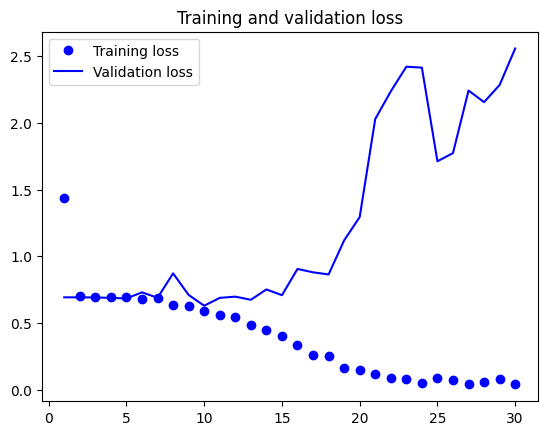

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set


In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 49ms/step - loss: 0.6221 - accuracy: 0.6510
Test accuracy: 0.651


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images


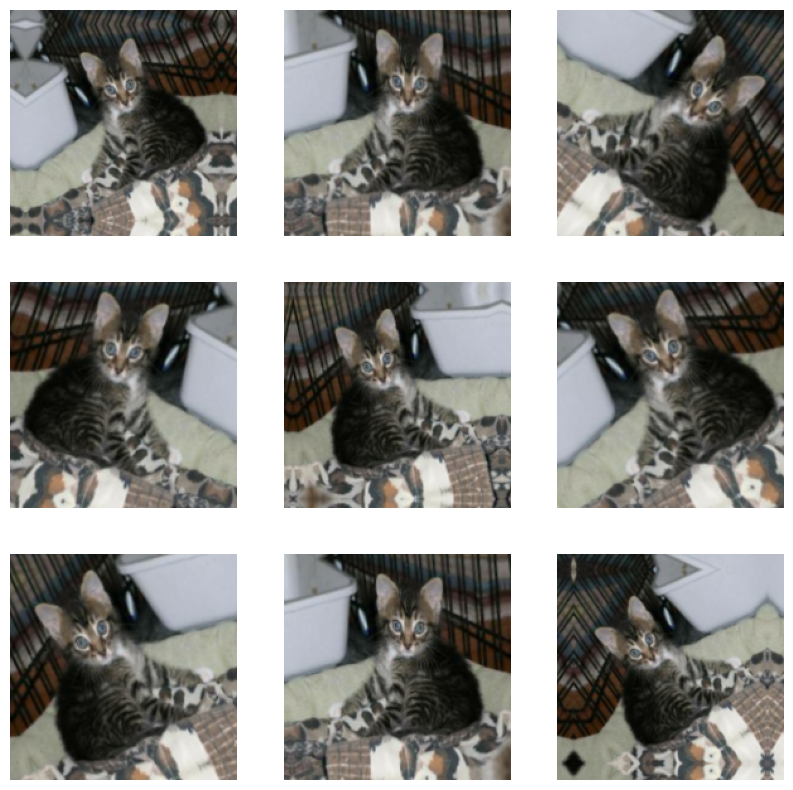

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Defining a new convnet that includes image augmentation and dropout

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras.X",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 10s 96ms/step - loss: 0.6953 - accuracy: 0.5200 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 7s 107ms/step - loss: 0.7013 - accuracy: 0.5200 - val_loss: 0.6874 - val_accuracy: 0.5800
Epoch 3/100
63/63 [==============================] - 6s 87ms/step - loss: 0.6875 - accuracy: 0.5430 - val_loss: 0.6781 - val_accuracy: 0.5390
Epoch 4/100
63/63 [==============================] - 8s 123ms/step - loss: 0.6716 - accuracy: 0.6025 - val_loss: 0.6306 - val_accuracy: 0.6440
Epoch 5/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6504 - accuracy: 0.6245 - val_loss: 0.6619 - val_accuracy: 0.5820
Epoch 6/100
63/63 [==============================] - 4s 62ms/step - loss: 0.6276 - accuracy: 0.6595 - val_loss: 0.6403 - val_accuracy: 0.6090
Epoch 7/100
63/63 [==============================] - 7s 98ms/step - loss: 0.6148 - accuracy: 0.6625 - val_loss: 0.6202 - val_accuracy: 0.6240
Epo

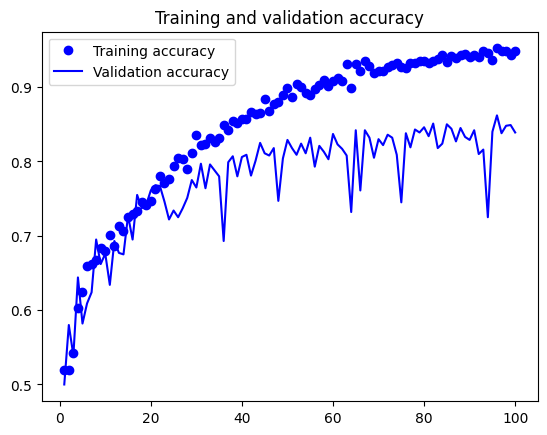

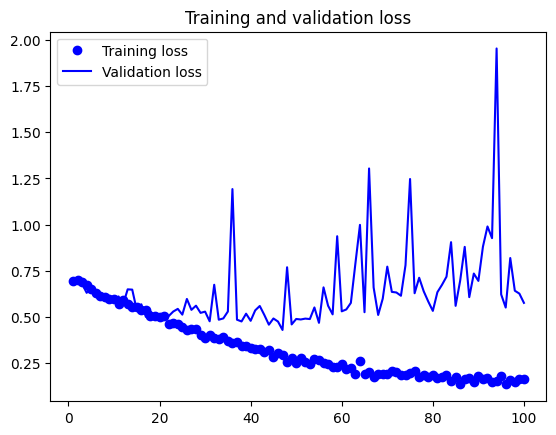

In [23]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [24]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras.X")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 32ms/step - loss: 0.4578 - accuracy: 0.8150
Test accuracy: 0.815


## Leveraging a pretrained model

**Instantiating the VGG16 convolutional base**

In [25]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [27]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


In [29]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [31]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 17ms/step - loss: 32.5074 - accuracy: 0.9170 - val_loss: 15.3947 - val_accuracy: 0.9190
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 3.5600 - accuracy: 0.9745 - val_loss: 5.1820 - val_accuracy: 0.9670
Epoch 3/20
63/63 [==============================] - 1s 13ms/step - loss: 1.8605 - accuracy: 0.9860 - val_loss: 3.3708 - val_accuracy: 0.9740
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.8635 - accuracy: 0.9860 - val_loss: 12.6080 - val_accuracy: 0.9430
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1.3977 - accuracy: 0.9875 - val_loss: 4.9455 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 1.2713 - accuracy: 0.9925 - val_loss: 4.4816 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 0.8195 - accuracy: 0.9930 - val_loss: 4.2042 - val_accuracy: 0.9730
Epoch 8/20
63/

**Plotting the results**

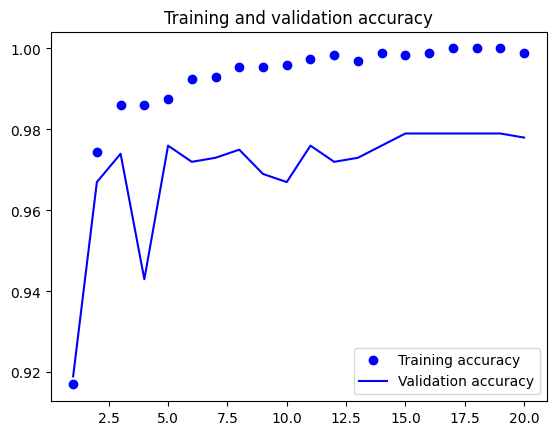

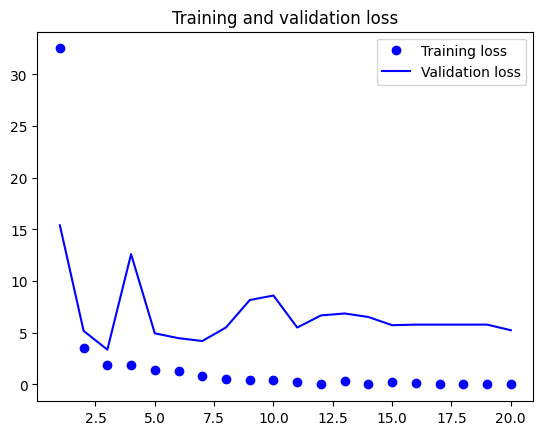

In [32]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [33]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [35]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26


In [36]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [37]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 32s 510ms/step - loss: 7.0063 - accuracy: 0.9505 - val_loss: 4.2102 - val_accuracy: 0.9740
Epoch 2/50
63/63 [==============================] - 12s 193ms/step - loss: 5.3761 - accuracy: 0.9600 - val_loss: 4.1074 - val_accuracy: 0.9730
Epoch 3/50
63/63 [==============================] - 10s 158ms/step - loss: 5.4957 - accuracy: 0.9535 - val_loss: 8.8721 - val_accuracy: 0.9560
Epoch 4/50
63/63 [==============================] - 12s 188ms/step - loss: 4.5396 - accuracy: 0.9645 - val_loss: 4.7992 - val_accuracy: 0.9710
Epoch 5/50
63/63 [==============================] - 13s 205ms/step - loss: 3.7750 - accuracy: 0.9680 - val_loss: 3.5725 - val_accuracy: 0.9780
Epoch 6/50
63/63 [==============================] - 10s 156ms/step - loss: 3.2945 - accuracy: 0.9690 - val_loss: 5.4810 - val_accuracy: 0.9640
Epoch 7/50
63/63 [==============================] - 10s 158ms/step - loss: 2.5532 - accuracy: 0.9725 - val_loss: 3.7389 - val_accuracy: 0.9800

**Evaluating the model on the test set**

In [41]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 101ms/step - loss: 2.0874 - accuracy: 0.9795
Test accuracy: 0.979


### Fine-tuning a pretrained model

In [42]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model


In [46]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 228ms/step - loss: 0.4332 - accuracy: 0.9900 - val_loss: 1.7114 - val_accuracy: 0.9790
Epoch 2/30
63/63 [==============================] - 14s 222ms/step - loss: 0.3220 - accuracy: 0.9890 - val_loss: 1.3191 - val_accuracy: 0.9840
Epoch 3/30
63/63 [==============================] - 11s 177ms/step - loss: 0.3770 - accuracy: 0.9890 - val_loss: 1.5360 - val_accuracy: 0.9840
Epoch 4/30
63/63 [==============================] - 11s 176ms/step - loss: 0.1552 - accuracy: 0.9945 - val_loss: 2.4786 - val_accuracy: 0.9750
Epoch 5/30
63/63 [==============================] - 11s 174ms/step - loss: 0.1858 - accuracy: 0.9930 - val_loss: 1.9377 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 11s 172ms/step - loss: 0.3030 - accuracy: 0.9920 - val_loss: 1.5952 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 11s 176ms/step - loss: 0.2575 - accuracy: 0.9925 - val_loss: 1.7286 - val_accuracy: 0.9810

In [48]:
model = keras.models.load_model("fine_tuning.keras.x")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 104ms/step - loss: 1.5174 - accuracy: 0.9760
Test accuracy: 0.976
